## Nominal KNN

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import sem
from scipy.stats import t

# Load your data
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
tmax_reduced = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
tmin_reduced = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
rain_reduced = block_reduce(rain, block_size=(12, 1, 1), func=np.mean, cval=np.mean(rain))
hurs_reduced = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
sun_reduced = block_reduce(sun, block_size=(12, 1, 1), func=np.mean, cval=np.mean(sun))
frost_reduced = block_reduce(frost, block_size=(12, 1, 1), func=np.mean, cval=np.mean(frost))
psl_reduced = block_reduce(psl, block_size=(12, 1, 1), func=np.mean, cval=np.mean(psl))
wind_reduced = block_reduce(wind, block_size=(12, 1, 1), func=np.mean, cval=np.mean(wind))

min_length = len(wind_reduced)
rain = rain_reduced[:min_length]
hurs = hurs_reduced[:min_length]
temp_reduced = temp_reduced[:min_length]
tmax_reduced = tmax_reduced[:min_length]
tmin_reduced = tmin_reduced[:min_length]
sun = sun_reduced[:min_length]
frost = frost_reduced[:min_length]
wind = wind_reduced[:min_length]
psl = psl_reduced[:min_length]

scaler = MinMaxScaler()

rain = scaler.fit_transform(rain.reshape(-1, 1)).flatten()
hurs = scaler.fit_transform(hurs.reshape(-1, 1)).flatten()
temp_annual_mean = scaler.fit_transform(temp_reduced.reshape(-1, 1)).flatten()
tmax_annual_mean = scaler.fit_transform(tmax_reduced.reshape(-1, 1)).flatten()
tmin_annual_mean = scaler.fit_transform(tmin_reduced.reshape(-1, 1)).flatten()
sun = scaler.fit_transform(sun.reshape(-1, 1)).flatten()
frost = scaler.fit_transform(frost.reshape(-1, 1)).flatten()
psl = scaler.fit_transform(psl.reshape(-1, 1)).flatten()
wind = scaler.fit_transform(wind.reshape(-1, 1)).flatten()

# Assuming temp, temp_max, and temp_min have shape (num_years, x, y)
num_years_temp, x, y = temp.shape

# Create an array of years to match the reshaped temperature arrays
years_expanded = np.repeat(np.arange(1969, 2023), x * y)

data_dict = {
    'Year': years_expanded,
    'Temperature': temp_annual_mean,
    'Maximum Temperature': tmax_annual_mean,
    'Minimum Temperature': tmin_annual_mean,
    'Rainfall': rain,
    'Humidity': hurs,
    'Ground Frost': frost,
    'Sunshine': sun,
    'Mean Sea Level Pressure': psl,
    'Wind Speed': wind
}

df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

# Training set score
train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

# Test set score
test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")

      Temperature  Maximum Temperature  Minimum Temperature  Rainfall  \
Year                                                                    
1969     0.503427             0.530206             0.397075  0.206214   
1969     0.468754             0.488834             0.374231  0.285411   
1969     0.403725             0.418404             0.330685  0.361803   
1969     0.504660             0.416010             0.552804  0.600102   
1969     0.444492             0.364899             0.520949  0.604795   
...           ...                  ...                  ...       ...   
2022     0.565655             0.539912             0.489399  0.247843   
2022     0.687914             0.674667             0.577863  0.166248   
2022     0.731090             0.726687             0.610029  0.127647   
2022     0.702006             0.685939             0.596843  0.126904   
2022     0.518845             0.463227             0.493467  0.359923   

      Humidity  Ground Frost  Sunshine  Mean Sea L

Average Accuracy: 0.6725
95% Confidence Interval: (0.5885165834668131, 0.7564524504861203)


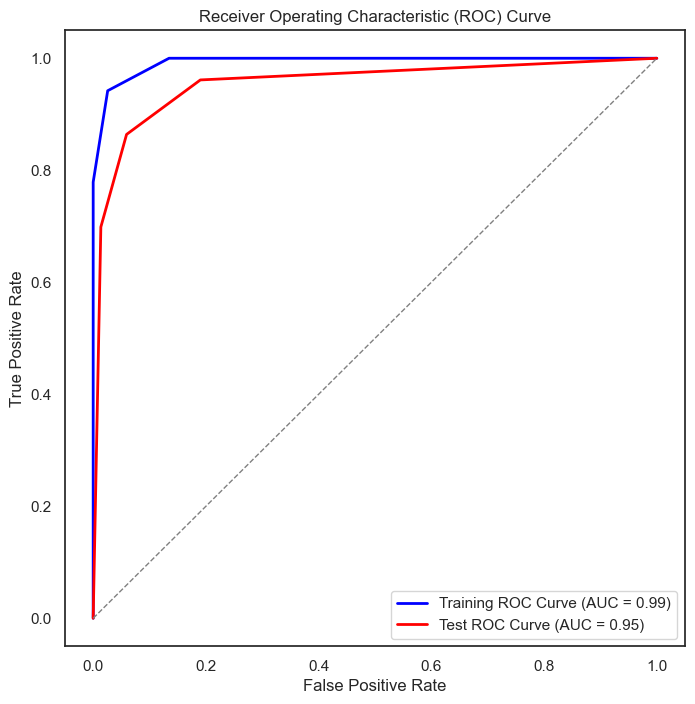

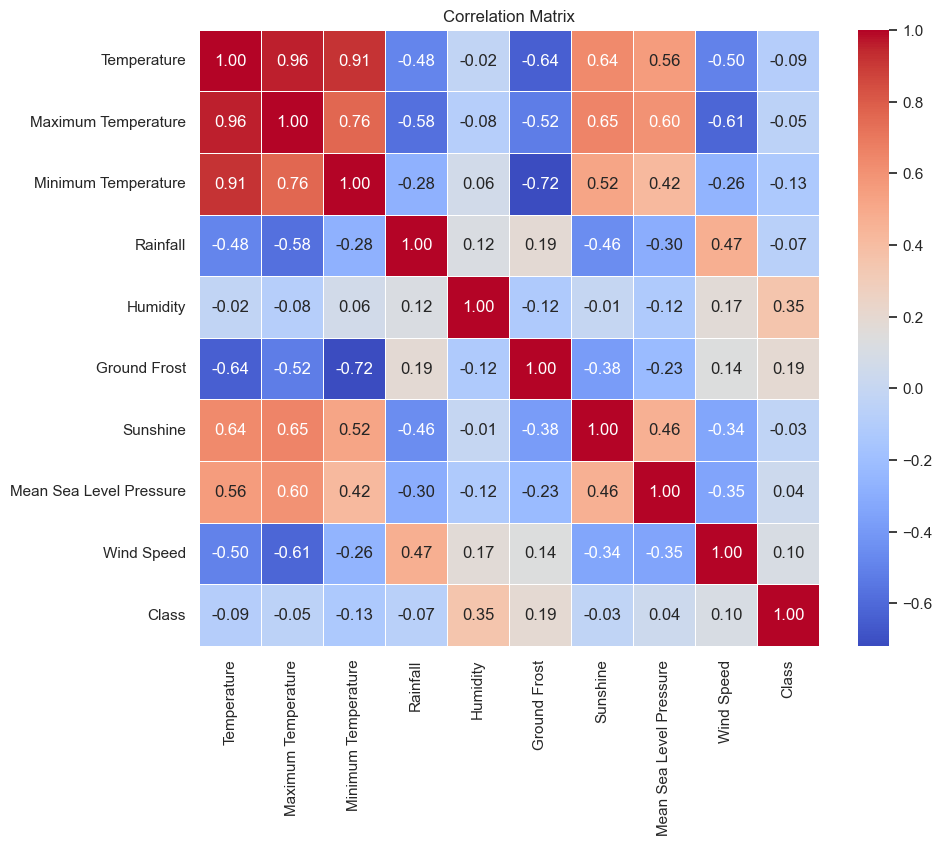

In [5]:
scores = cross_val_score(knn, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)


le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

correlation_matrix = df.corr()
sns.set(style="white")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

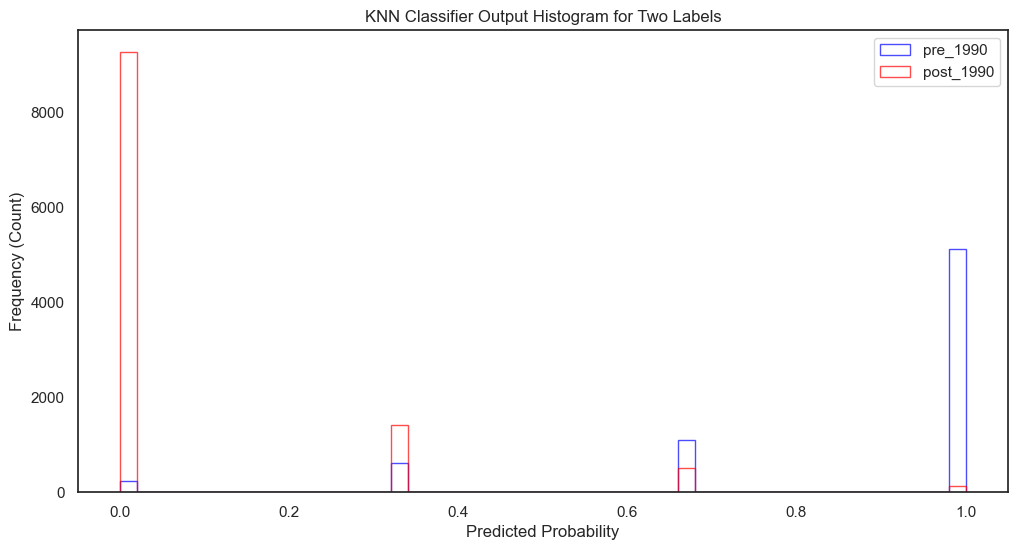

In [58]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

# Specify the two labels for which you want to create histograms
label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')

plt.title('KNN Classifier Output Histogram for Two Labels')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()
